In [5]:
import os
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import requests
import tarfile
from io import BytesIO, StringIO
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist["data"], mnist["target"]

In [6]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

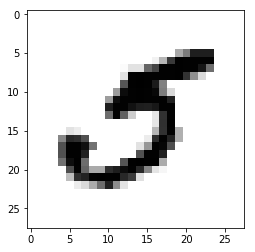

In [9]:
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest");

In [10]:
y[36000]

5.0

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [13]:
y_train_5 = (y_train == 5)

In [14]:
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

In [24]:
sgd_clf = SGDClassifier(max_iter=5,tol=None,random_state=42)

In [25]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [20]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [22]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [26]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.096
0.0953
0.0975


In [91]:
from sklearn.model_selection import cross_val_predict, cross_val_score

In [28]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_train_5, y_train_pred)

array([[53534,  1045],
       [ 1439,  3982]])

In [31]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y_train_5,y_train_pred))

             precision    recall  f1-score   support

      False       0.97      0.98      0.98     54579
       True       0.79      0.73      0.76      5421

avg / total       0.96      0.96      0.96     60000



In [36]:
y_scores = sgd_clf.decision_function([some_digit])

In [37]:
y_scores

array([ 34065.89343645])

In [38]:
threshold = 0

In [39]:
y_some_digit_pred = (y_scores > threshold)

In [40]:
y_some_digit_pred

array([ True], dtype=bool)

In [41]:
threshold = 200000

In [42]:
(y_scores > threshold)

array([False], dtype=bool)

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3, method="decision_function")

In [44]:
from sklearn.metrics import precision_recall_curve

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [58]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

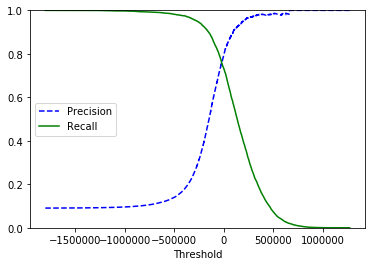

In [59]:
plot_precision_recall_vs_threshold(precisions, recalls,thresholds)
plt.show();

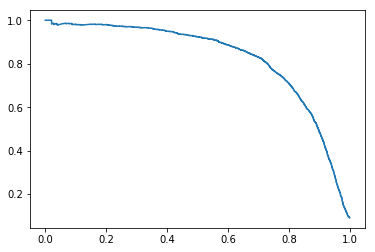

In [62]:
plt.plot(recalls,precisions)

In [63]:
y_train_pred_90 = (y_scores > 70000)

In [ ]:
y_some_digit_pred = (y_scores > threshold)

In [64]:
from sklearn.metrics import precision_score, recall_score

In [65]:
precision_score(y_train_5, y_train_pred_90)

0.87771667975909928

In [66]:
recall_score(y_train_5,y_train_pred_90)

0.6183361003504888

In [67]:
from sklearn.metrics import roc_curve

In [68]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

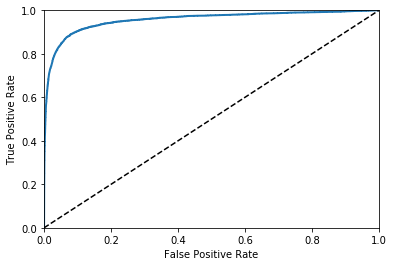

In [70]:
plot_roc_curve(fpr,tpr)
plt.show();

In [71]:
from sklearn.metrics import roc_auc_score

In [72]:
roc_auc_score(y_train_5, y_scores)

0.95646502556188351

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,
                                   method="predict_proba")


In [77]:
y_scores_pos_forest = y_probas_forest[:,1]

In [79]:
fpr_forest, tpr_forest, thresholds_forest = \
    roc_curve(y_train_5,y_scores_pos_forest)

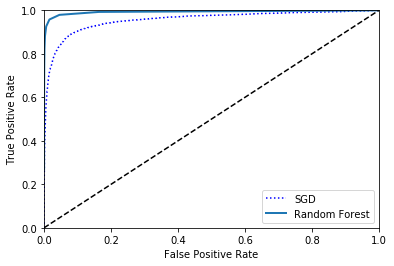

In [80]:
plt.plot(fpr,tpr,"b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show();

In [81]:
roc_auc_score(y_train_5,y_scores_pos_forest)

0.99295268511015589

Multiclass classifiers: Random Forest, Naive Bayes

Binary classifiers: SVM, Linear, Stochastic Gradient

Binary classifier strategies: one-v-all (N), one-v-one (N^2-N)/2

In [82]:
# Automatic o-v-a when using a binary clf (except SVM o-v-o)

In [83]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [85]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -36212.67469898, -420903.65586063, -385248.61364576,
         -43233.85884799, -440987.21537098,   34065.89343645,
        -633981.04656494, -328859.53896634, -610241.2523547 ,
        -779617.69233318]])

In [86]:
# Random Forest
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [87]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [88]:
# eval SGD

In [92]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([ 0.85932813,  0.87059353,  0.85962894])

In [93]:
# scale inputs to improve score

In [94]:
from sklearn.preprocessing import StandardScaler

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [100]:
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([ 0.91026795,  0.91169558,  0.90828624])

In [101]:
# Check metrics - confusion matrix, etc.

In [102]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)

In [103]:
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5726,    4,   20,   11,    9,   55,   47,    8,   40,    3],
       [   2, 6468,   41,   31,    6,   41,    8,   16,  117,   12],
       [  50,   42, 5314,  107,   82,   23,  102,   58,  164,   16],
       [  50,   28,  137, 5356,    1,  235,   35,   60,  143,   86],
       [  17,   26,   41,   11, 5340,   10,   57,   35,   84,  221],
       [  67,   41,   32,  190,   71, 4606,  117,   28,  173,   96],
       [  30,   25,   48,    2,   39,   86, 5642,    6,   40,    0],
       [  24,   19,   67,   34,   49,   12,    4, 5840,   16,  200],
       [  51,  143,   74,  160,   13,  157,   57,   26, 5044,  126],
       [  38,   29,   27,   90,  147,   38,    3,  225,   83, 5269]])

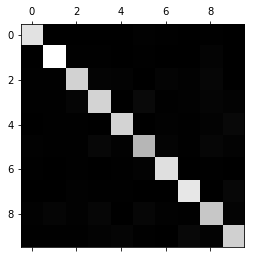

In [105]:
plt.matshow(conf_mx,cmap=plt.cm.gray);

In [118]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [146]:
norm_conf_mx = conf_mx / row_sums

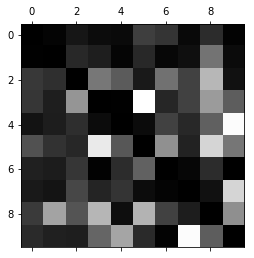

In [124]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray);

In [143]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

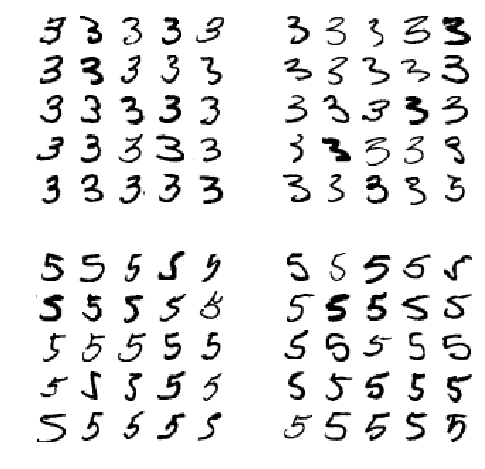

In [145]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train==cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred == cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred == cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show();
